# Indefinite integration

The simplest possible context for our first finite-difference method is the BVP

$$
u'(x) = g(x), \quad u(a)=0, \quad a < x < b. 
$$

The solution of this problem is just an indefinite integral of $g$. Suppose we discretize the domain $[a,b]$ by choosing the nodes

$$
x_i = a + ih, \quad h = \frac{b-a}{n}, \quad i=0,\ldots,n,
$$

for a positive integer $n$. If we want to write a discrete analog of the ODE at each node, then at the first node $x_0$ we really only have one of the three options above available, the forward difference. Likewise, at $x_n$ we can only use the backward difference. At the interior nodes, suppose that we use a centered difference. This gives us the discrete equations

$$
\frac{u_1-u_0}{h} = g(x_0), \, \frac{u_2-u_0}{2h} = g(x_1), \, \cdots \, \frac{u_n-u_{n-2}}{2h} = g(x_{n-1}),  \, \frac{u_n-u_{n-1}}{h} = g(x_{n}). 
$$

It's much saner to express these using linear algebra:

$$
\frac{1}{2h}
\begin{bmatrix} 
-2 & 2 & & & \\ 
-1 & 0 & 1 & & \\ 
& \ddots & \ddots & \ddots  & \\ 
& & -1 & 0 & 1 \\ 
& & & -2 & 2 
\end{bmatrix} 
\begin{bmatrix} u_0 \\ u_1 \\ \vdots \\ u_{n-1} \\ u_n   \end{bmatrix}
= 
\begin{bmatrix} g(x_0) \\ g(x_1) \\ \vdots \\ g(x_{n-1}) \\ g(x_n)   \end{bmatrix}. 
$$

We will call the matrix in this system a **differentiation matrix**. It maps a vector of function values to a vector of (approximate) values of its derivative.

In [1]:
using LinearAlgebra
function diffmat1(x)
    # assumes evenly spaced nodes
    h = x[2]-x[1]
    m = length(x)
    Dx = 1/2h*diagm(-1=>[-ones(m-2);-2],0=>[-2;zeros(m-2);2],1=>[2;ones(m-2)])
end

a,b = 0,1
g = x->cos(x)

n = 8
h = (b-a)/n
x = [a + i*h for i in 0:n]
A = diffmat1(x)

9×9 Matrix{Float64}:
 -8.0   8.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
 -4.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0  0.0
  0.0  -4.0   0.0   4.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0  -4.0   0.0   4.0   0.0   0.0   0.0  0.0
  0.0   0.0   0.0  -4.0   0.0   4.0   0.0   0.0  0.0
  0.0   0.0   0.0   0.0  -4.0   0.0   4.0   0.0  0.0
  0.0   0.0   0.0   0.0   0.0  -4.0   0.0   4.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -4.0   0.0  4.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -8.0  8.0

In [2]:
b = g.(x)
u = A\b

LoadError: SingularException(9)

Wait, what??

Sometimes when the discrete analog of the problem fails spectacularly, it's actually reflecting an important property of the original problem. Here, we've forgotten to impose the boundary/initial condition $u(a)=0$, and that makes the problem ill-posed. In fact, we know that the integration problem has a 1-dimensional nonuniqueness, and so does the matrix problem here:

In [3]:
U,σ,V = svd(A)
σ

9-element Vector{Float64}:
 12.100392721451549
 12.089289539656962
  7.471591835346571
  7.185353763395404
  5.8641393337995735
  5.245446585976806
  3.2418642763057655
  2.7501012990954647
  5.3315209669936526e-17

The null space even consists of a constant solution:

In [4]:
V[:,end]

9-element Vector{Float64}:
 -0.3333333333333333
 -0.3333333333333333
 -0.3333333333333333
 -0.3333333333333333
 -0.3333333333333332
 -0.3333333333333332
 -0.3333333333333331
 -0.33333333333333304
 -0.33333333333333315

Let's impose the boundary condition now. In order to keep this a square linear system, we need to replace a row, not add one; the natural choice is the first row.

In [5]:
A[1,1:2] = [1,0];  b[1] = 0;
u = A\b 

9-element Vector{Float64}:
 -2.7755575615628914e-17
  0.1315825653503195
  0.24804941680733222
  0.3738106707779807
  0.4806763222854108
  0.5932063112505739
  0.6834171021617153
  0.7761285284690291
  0.8436663167025465

Compare to the exact solution, $u(x)=\sin(x)$:

In [6]:
[u sin.(x)]

9×2 Matrix{Float64}:
 -2.77556e-17  0.0
  0.131583     0.124675
  0.248049     0.247404
  0.373811     0.366273
  0.480676     0.479426
  0.593206     0.585097
  0.683417     0.681639
  0.776129     0.767544
  0.843666     0.841471

While that's plausible, it's not conclusively correct. Let's do a convergence study.

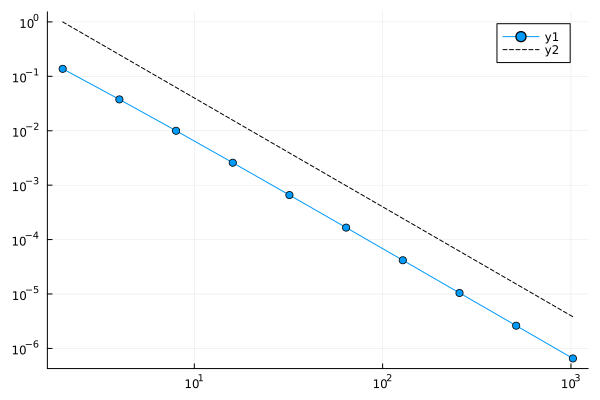

In [7]:
function fdintegrate(g,a,b,n)
    h = (b-a)/n
    x = [a + i*h for i in 0:n]
    A = diffmat1(x)
    b = g.(x)

    A[1,1:2] = [1,0];  b[1] = 0;
    
    u = A\b 
    return x,u
end

n = [2^k for k in 1:10]
err = []
for n in n
    x,u = fdintegrate(cos,0,1,n)
    û = sin.(x)
    push!(err,norm(u-û)/norm(û))
end

using Plots
plot(n,err,m=4,xaxis=:log10,yaxis=:log10)
order1 = @. (n/n[1])^(-2)
plot!(n,order1,color=:black,l=:dash)

The straight-line convergence on log-log scales means **algebraic convergence** of the rate $C n^{-p}$ for a positive **order** $p$. The dashed black line shows $p=2$. How do we explain this convergence order? Stay tuned.